<a href="https://colab.research.google.com/github/SamanvayMS/FIN-554-Algo-trading-finalproject/blob/main/VWAP_hypothesis_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [2]:
pip install update pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
yf.pdr_override()

In [5]:
start='2000-01-01'
end='2010-01-01'
df = yf.download('SPY',start,end)

[*********************100%***********************]  1 of 1 completed


In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
def data_prep_VWAP(symbol,lookback,start,end):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  df['PV'] = df['Close'] * df['Volume']
  df['CumulativePV'] = df['PV'].rolling(lookback).sum()

  # Calculate the cumulative sum of volume
  df['CumulativeVolume'] = df['Volume'].rolling(lookback).sum()

  # Calculate the rolling VWAP
  df['RollingVWAP'] = df['CumulativePV'] / df['CumulativeVolume']
  df['signal']=np.where(df['Open']>df['RollingVWAP'].shift(1),1,0)
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df['shifted_returns']=df['returns'].shift(-1)
  df['direction'] = [1 if x>0 else 0 for x in df['returns']]
  df=df.dropna(axis=0)
  return df

In [8]:
# here we look at stcoks from all the sectors of the market
sectors = ['Tech','Healthcare','Financial','Consumer_D','Consumer_S','Industrial','Energy','Utility','Market_ETF']
Tech_stocks=['AAPL','MSFT','NVDA','ADBE','CRM','GOOGL','AMZN','IBM','INTC','CSCO']
Healthcare_stocks=['JNJ','PFE','MRK','GILD','AMGN','BMY','LLY','REGN','UNH']
Financial_stocks=["JPM", "BAC", "WFC", "C", "GS", "MS", "V", "MA", "AXP", "SCHW"]
Consumer_D_stocks = ["HD", "MCD", "NKE", "SBUX", "DIS", "CMCSA", "LOW", "GM", "F", "BKNG"] # Consumer discretionary
Consumer_S_stocks= ["PG", "KO", "PEP", "WMT", "CL", "KMB", "CLX", "MDLZ", "EL"] #Consumer Staples
Industrial_stocks = ["BA", "GE", "MMM", "HON", "CAT", "RTX", "LMT", "GD", "UNP", "FDX"]
Energy_stocks = ["XOM", "CVX", "BP", "COP", "EOG", "OXY", "SLB", "KMI", "WMB"]
Utility_stocks = ["NEE", "DUK", "D", "SO", "EXC", "AEP", "SRE", "XEL", "WEC", "AWK"]
Market_ETF_stocks = ['SPY','QQQ']

### Asset selection for tests
selected a bunch of stocks from each sector for running and analysing the stocks and their sector wise dependence.
pros- can identify the sector wise dependence of stocks on indicators 
cons - 
survivorship bias as some stocks might delisted or just added 
overfitting bias as we are cherry picking stocks based on p value 


In [9]:
lookbacks=[9,20,50,100,200]

In [10]:
start='2000-01-01'
end='2015-01-01'

# Hypothesis Tests 


chi_squared test

In [11]:
from scipy.stats import chi2_contingency

H0 :- null hypothesis assumes no significant relationship between opening price and the previous rolling VWAP value

H1 :- significant relationship with the previous VWAP value bullish when above VWAP and bearish when below VWAP

In [16]:
def chi_2(Symbol,lookback,start,end,print_results=False):
  df = data_prep_VWAP(Symbol,lookback,start=start,end=end)
  observed=pd.crosstab(df['direction'],df['signal'])
  result = chi2_contingency(observed)
  if print_results:
    print(f"p value for {Symbol} is {result[1]}")
    if result[1]>0.01:
      print("null hypothesis cannot be rejected")
    else:
      print("null hypothesis is rejected")
  return result[1]

In [ ]:
chi_2_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  chi_2_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    chi_2_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      p_value = chi_2(stock,lookback,start,end)
      if p_value<0.01:
        chi_2_hypothesis_rejected[sector][stock][lookback]=p_value


In [18]:
chi_2_hypothesis_rejected

{'Tech': {'AAPL': {},
  'MSFT': {},
  'NVDA': {},
  'ADBE': {},
  'CRM': {},
  'GOOGL': {},
  'AMZN': {},
  'IBM': {20: 0.0003933374223075785, 50: 0.005795068877007131},
  'INTC': {20: 0.0020609451175740297},
  'CSCO': {}},
 'Healthcare': {'JNJ': {},
  'PFE': {},
  'MRK': {},
  'GILD': {9: 0.00919626934116465},
  'AMGN': {9: 0.007284184630483424},
  'BMY': {},
  'LLY': {},
  'REGN': {},
  'UNH': {}},
 'Financial': {'JPM': {},
  'BAC': {50: 0.0005890366935155224,
   100: 0.0005184820071771116,
   200: 0.0007425453291513781},
  'WFC': {9: 8.62253117314433e-06, 20: 0.00017508040612170184},
  'C': {},
  'GS': {},
  'MS': {},
  'V': {},
  'MA': {},
  'AXP': {},
  'SCHW': {}},
 'Consumer_D': {'HD': {},
  'MCD': {},
  'NKE': {},
  'SBUX': {9: 0.003687509426692019},
  'DIS': {},
  'CMCSA': {},
  'LOW': {},
  'GM': {},
  'F': {},
  'BKNG': {}},
 'Consumer_S': {'PG': {},
  'KO': {200: 0.007168283663723792},
  'PEP': {},
  'WMT': {},
  'CL': {9: 0.007012278805522372},
  'KMB': {9: 1.0437882179628

wilcox rank test

In [19]:
from scipy.stats import ranksums
from scipy.stats import shapiro
from scipy.stats import ttest_ind

H0:-There is no significant relationship between the returns and the price's position relative to the VWAP.

H1:-The returns are significantly positive when the price is above the VWAP and significantly negative when the price is below the VWAP.

In [20]:
def tests(Symbol,lookback,start,end,print_results=False):
  df = data_prep_VWAP(Symbol,lookback,start=start,end=end)
  above_vwap = df[df['Open'] > df['RollingVWAP'].shift(1)]['returns']
  below_vwap = df[df['Open'] < df['RollingVWAP'].shift(1)]['returns']

  #plt.hist(above_vwap,bins=30,color="green",alpha=0.5)
  #plt.hist(below_vwap,bins=30,color="red",alpha=0.5)
  #plt.show()
  _, p_value1 = shapiro(above_vwap)
  _, p_value2 = shapiro(below_vwap)
  if p_value1 > 0.01 and p_value2 > 0.01:
    if print_results:
      print("returns are normally distributed")
      print("we can run a t-test")
    stat, p_value = ttest_ind(above_vwap, below_vwap, equal_var=True)
  else:
    if print_results:
      print("returns are not normally distributed")
      print("we can run a Wilcox Rank Sum test")    
    stat, p_value = ranksums(above_vwap, below_vwap)
  if print_results:
    print(f"p value for {Symbol} is {p_value}")
    if p_value>0.01:
      print("null hypothesis cannot be rejected")
    else:
      print("null hypothesis is rejected")
  return p_value

In [ ]:
WRT_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  WRT_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    WRT_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      p_value = tests(stock,lookback,start,end)
      if p_value<0.01:
        WRT_hypothesis_rejected[sector][stock][lookback]=p_value

In [22]:
WRT_hypothesis_rejected

{'Tech': {'AAPL': {},
  'MSFT': {},
  'NVDA': {},
  'ADBE': {},
  'CRM': {},
  'GOOGL': {},
  'AMZN': {},
  'IBM': {20: 0.0006255734776664737, 50: 0.001610956326933965},
  'INTC': {20: 0.000533032039013402},
  'CSCO': {}},
 'Healthcare': {'JNJ': {},
  'PFE': {9: 0.005478483196909184},
  'MRK': {},
  'GILD': {9: 0.004323705822781134},
  'AMGN': {9: 0.0010373070037304369},
  'BMY': {},
  'LLY': {},
  'REGN': {},
  'UNH': {}},
 'Financial': {'JPM': {},
  'BAC': {50: 0.0004564519053231335,
   100: 0.0015538785389765221,
   200: 0.0022911524629394375},
  'WFC': {9: 3.82808183491118e-06, 20: 0.00019782077853659394},
  'C': {50: 0.0017486252459858237},
  'GS': {50: 0.008971638874822664},
  'MS': {},
  'V': {},
  'MA': {},
  'AXP': {},
  'SCHW': {}},
 'Consumer_D': {'HD': {},
  'MCD': {},
  'NKE': {},
  'SBUX': {9: 0.0010510966876230764},
  'DIS': {},
  'CMCSA': {},
  'LOW': {},
  'GM': {},
  'F': {50: 0.0002781692863749967,
   100: 0.0001771870500998433,
   200: 0.007854315333134751},
  'BKNG

# Taking moving averages


In [23]:
def data_prep_MA(symbol,lookback,start,end,smoothing_choice="s"):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  # Calculate the rolling MAs
  if smoothing_choice=='s':
    df['SMA']=df['Close'].rolling(window=lookback).mean()
  elif smoothing_choice=='e':
    df['EMA']=df['Close'].ewm(span=lookback, adjust=False).mean()
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df=df.dropna(axis=0)
  return df

In [24]:
data_prep_MA('AAPL',lookback,start,end,'s')

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,SMA,returns
Date,,,,,,,,
2000-10-16,0.398438,0.415179,0.381696,0.383929,0.326769,820176000,0.946176,-0.036415
2000-10-17,0.387277,0.391741,0.351563,0.359375,0.305871,601720000,0.942976,-0.072047
2000-10-18,0.347098,0.376116,0.334821,0.359375,0.305871,834265600,0.940197,0.035370
2000-10-19,0.342076,0.353795,0.327009,0.338170,0.287823,1506724800,0.937245,-0.011419
2000-10-20,0.340402,0.363839,0.338170,0.348214,0.296371,791263200,0.934745,0.022949
...,...,...,...,...,...,...,...,...
2014-12-24,28.145000,28.177500,28.002501,28.002501,25.167873,57918400,23.937804,-0.005063
2014-12-26,28.025000,28.629999,28.002501,28.497499,25.612766,134884000,23.985532,0.016860
2014-12-29,28.447500,28.692499,28.424999,28.477501,25.594790,110395600,24.034225,0.001055


In [25]:
def tests_MA(symbol,lookback,start,end,smoothing_choice,print_results=False,plot_dist=False):
  if smoothing_choice=='s':
    column='SMA'
  elif smoothing_choice=='e':
    column='EMA'
  else:
    print("invalid MA choice")
  df = data_prep_MA(symbol,lookback,start,end,smoothing_choice)
  above_ma = df[df['Open'] > df[column].shift(1)]['returns']
  below_ma = df[df['Open'] < df[column].shift(1)]['returns']
  if plot_dist:
    plt.hist(above_ma,bins=30,color="green",alpha=0.5)
    plt.hist(below_ma,bins=30,color="red",alpha=0.5)
    plt.show()
  
  _, p_value1 = shapiro(above_ma)
  _, p_value2 = shapiro(below_ma)
  if p_value1 > 0.01 and p_value2 > 0.01:
    if print_results:
      print("returns are normally distributed")
      print("we can run a t-test")
    stat, p_value = ttest_ind(above_ma, below_ma, equal_var=True)
  else:
    if print_results:
      print("returns are not normally distributed")
      print("we can run a Wilcox Rank Sum test")    
    stat, p_value = ranksums(above_ma, below_ma)
  if print_results:
    print(f"p value for {symbol} is {p_value}")
    if p_value>0.01:
      print("null hypothesis cannot be rejected")
    else:
      print("null hypothesis is rejected")
  return p_value

In [ ]:
EMA_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  EMA_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    EMA_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      EMA_hypothesis_rejected[sector][stock][lookback]={}
      for ma_type in ['s','e']:
        p_value = tests(stock,lookback,start,end)
        if p_value<0.01:
          EMA_hypothesis_rejected[sector][stock][lookback][ma_type]=p_value

# VWAP strat

Instead of checking for daily returns we are going to check for cummulative returns.
we can do this by testing the strategy compared to that of a benchmark strategy sucha s a buy and hold. 
we test the hypothesis that the cummulative returns generated by the VWAP strategy are not different from that generated by a single trade with the vwap strategy 

Use one tailed paired t-test for confirming this hypothesis

In [27]:
def data_prep_VWAP2(symbol,lookback,start,end):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  df['PV'] = df['Close'] * df['Volume']
  df['CumulativePV'] = df['PV'].rolling(lookback).sum()

  # Calculate the cumulative sum of volume
  df['CumulativeVolume'] = df['Volume'].rolling(lookback).sum()

  # Calculate the rolling VWAP
  df['RollingVWAP'] = df['CumulativePV'] / df['CumulativeVolume']
  df['returns']=(df['Close']-df['Close'].shift(1))/df['Close'].shift(1)
  df["day's return"]=(df['Close']-df['Open'])/df['Open']
  df=df.dropna(axis=0)
  return df

In [28]:
data_prep_VWAP2('AAPL',22,start,end)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,PV,CumulativePV,CumulativeVolume,RollingVWAP,returns,day's return
Date,,,,,,,,,,,,
2000-02-02,0.899554,0.911830,0.866071,0.882254,0.750903,464195200,4.095381e+08,1.227971e+10,1.333741e+10,0.920697,-0.014339,-0.019232
2000-02-03,0.895647,0.930804,0.895089,0.922433,0.785100,475193600,4.383343e+08,1.218254e+10,1.327680e+10,0.917581,0.045541,0.029907
2000-02-04,0.928013,0.982143,0.925223,0.964286,0.820721,425320000,4.101301e+08,1.212376e+10,1.318975e+10,0.919180,0.045372,0.039087
2000-02-07,0.964286,1.020089,0.945871,1.018415,0.866792,441067200,4.491894e+08,1.185022e+10,1.285249e+10,0.922017,0.056134,0.056134
2000-02-08,1.017857,1.036830,0.993304,1.025670,0.872967,408643200,4.191331e+08,1.161795e+10,1.249316e+10,0.929944,0.007124,0.007676
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,28.145000,28.177500,28.002501,28.002501,25.167871,57918400,1.621860e+09,1.271327e+11,4.491455e+09,28.305468,-0.004709,-0.005063
2014-12-26,28.025000,28.629999,28.002501,28.497499,25.612768,134884000,3.843857e+09,1.253475e+11,4.436536e+09,28.253464,0.017677,0.016860
2014-12-29,28.447500,28.692499,28.424999,28.477501,25.594793,110395600,3.143791e+09,1.203957e+11,4.271570e+09,28.185344,-0.000702,0.001055


Trade Entry :- we wait for close to cross above VWAP and then enter at next days Open
Exit :- Once the Close is  below the VWAP we exit the position and take a short on the next days open (Ignoring Slippage)

In [66]:
def VWAP_crossover(symbol,lookback,start,end,print_trades=False):
  df = data_prep_VWAP2(symbol,lookback,start,end) # prepares the dataset
  df['strat_returns']=np.zeros(len(df)) # initialise the strategy column
  long_trade=False # sets long and short trade indicator to false 
  short_trade=False
  for date in df.index:
    if long_trade: 
      if just_entered:
        if print_trades:
          print('entered long trade',df.loc[date,"day's return"])
        df.loc[date,'strat_returns'] = df.loc[date,"day's return"]
        just_entered=False
      else:   
        if print_trades:
          print('in long trade',df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = df.loc[date,'returns']
    elif short_trade:
      if just_entered:
        if print_trades:
          print('entered short trade',-df.loc[date,"day's return"])
        df.loc[date,'strat_returns'] = -df.loc[date,"day's return"]
        just_entered=False
      else:      
        if print_trades:
          print('in short trade',-df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = -df.loc[date,'returns']
    else:
      df.loc[date,'strat_returns'] = 0
    if df.loc[date,'Close'] > df.loc[date,'RollingVWAP']:
      if long_trade==False:
        just_entered=True
      long_trade=True
      short_trade=False
    else:
      if short_trade==False:
        just_entered=True
      long_trade=False
      short_trade=True
  return df

In [ ]:
ret=VWAP_crossover('D',100,start='2010-01-01',end='2011-01-01')
ret

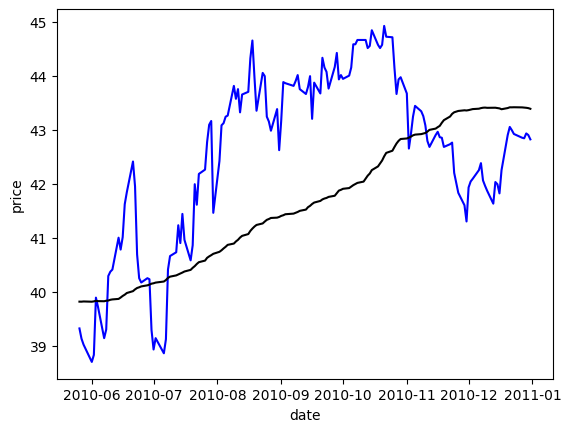

In [70]:
plt.plot(ret['Open'],c='blue')
plt.plot(ret['RollingVWAP'],c='black')
plt.xlabel('date')
plt.ylabel('price')
plt.show()

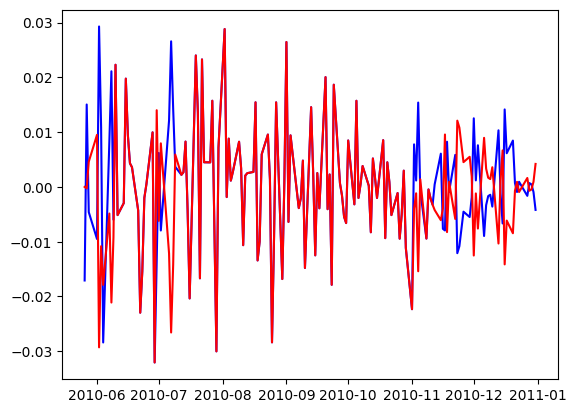

In [71]:
plt.plot(ret['returns'],c='blue')
plt.plot(ret['strat_returns'],c='red')
plt.show()

In [72]:
def cumret(returns):
  return (returns+1).cumprod()

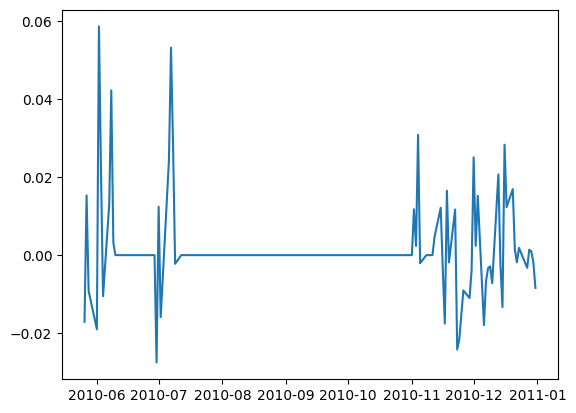

In [73]:
plt.plot(ret['returns']-ret['strat_returns'])

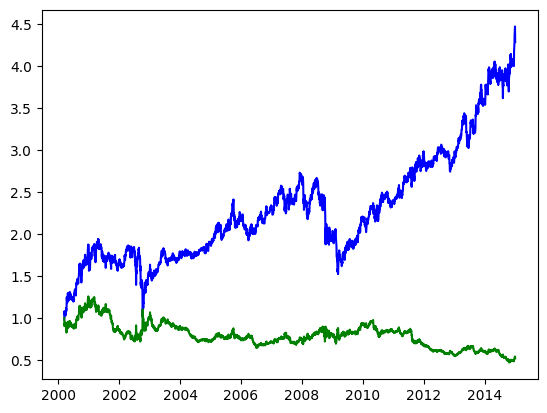

In [49]:
plt.plot(cumret(ret['returns']),c='blue')
plt.plot(cumret(ret['strat_returns']),c='green')
plt.show()

upon close examination we see lot of errors with our entry instead we added a slight modification in order to confirm our entries where we look at both previous days close and current days open to take our entries. 

In [81]:
def statistics(df,get_plots=False):
  if isinstance(df, pd.DataFrame):
    """
    Calculates the drawdowns given a column of daily returns.
    Returns a pandas DataFrame with columns for daily returns,
    cumulative returns, and drawdowns.
    """
    # Calculate cumulative returns
    cum_returns = (1 + df.returns).cumprod()
    cum_returns_strat = (1 + df.strat_returns).cumprod()
    # Calculate the previous peaks
    previous_peaks = cum_returns.cummax()
    previous_peaks_strat = cum_returns_strat.cummax()

    # Calculate the drawdowns
    drawdowns = (cum_returns - previous_peaks) / previous_peaks
    drawdowns_strat = (cum_returns_strat - previous_peaks_strat) / previous_peaks_strat
    # Create a DataFrame with the results
    results = pd.DataFrame({'Cumulative Returns': cum_returns,
                            'Strategy Cumulative Returns': cum_returns_strat,
                            'Drawdowns': drawdowns,
                            'Strategy Drawdowns': drawdowns_strat})
    if get_plots==False:
      return results
    fig,axs = plt.subplots(3,figsize=(10,15))
    axs[0].plot(results.iloc[:,:2],label=results.columns[:2])
    axs[0].set_title('cummulative returns')
    axs[0].set_ylabel('Returns')
    axs[0].set_xlabel('date')
    axs[0].legend()
    axs[1].plot(results.iloc[:,2:],label=results.columns[2:])
    axs[1].set_title('drawdown')
    axs[1].set_ylabel('drawdown')
    axs[1].set_xlabel('date')
    axs[0].legend()
    axs[2].hist(df.returns,alpha=0.5,bins=30,label='benchmark')
    axs[2].hist(df.strat_returns,alpha=0.5,bins=30,label='strategy')
    axs[2].set_title('distribution of returns')
    axs[2].set_xlabel('returns')
    axs[2].set_ylabel('frequency')
    axs[2].legend()
    fig.show()
    return results
  else:
    print('invalid Datatype')
    return None



,Cumulative Returns,Strategy Cumulative Returns,Drawdowns,Strategy Drawdowns
Date,,,,
2010-05-26,0.982921,1.000000,0.000000,0.000000
2010-05-27,0.997706,0.999744,0.000000,-0.000256
2010-05-28,0.993118,1.004342,-0.004599,0.000000
2010-06-01,0.983686,1.013880,-0.014052,0.000000
2010-06-02,1.012490,0.984192,0.000000,-0.029282
...,...,...,...,...
2010-12-27,1.093296,0.868164,-0.045191,-0.143721
2010-12-28,1.094061,0.867557,-0.044524,-0.144320
2010-12-29,1.094570,0.867153,-0.044078,-0.144719


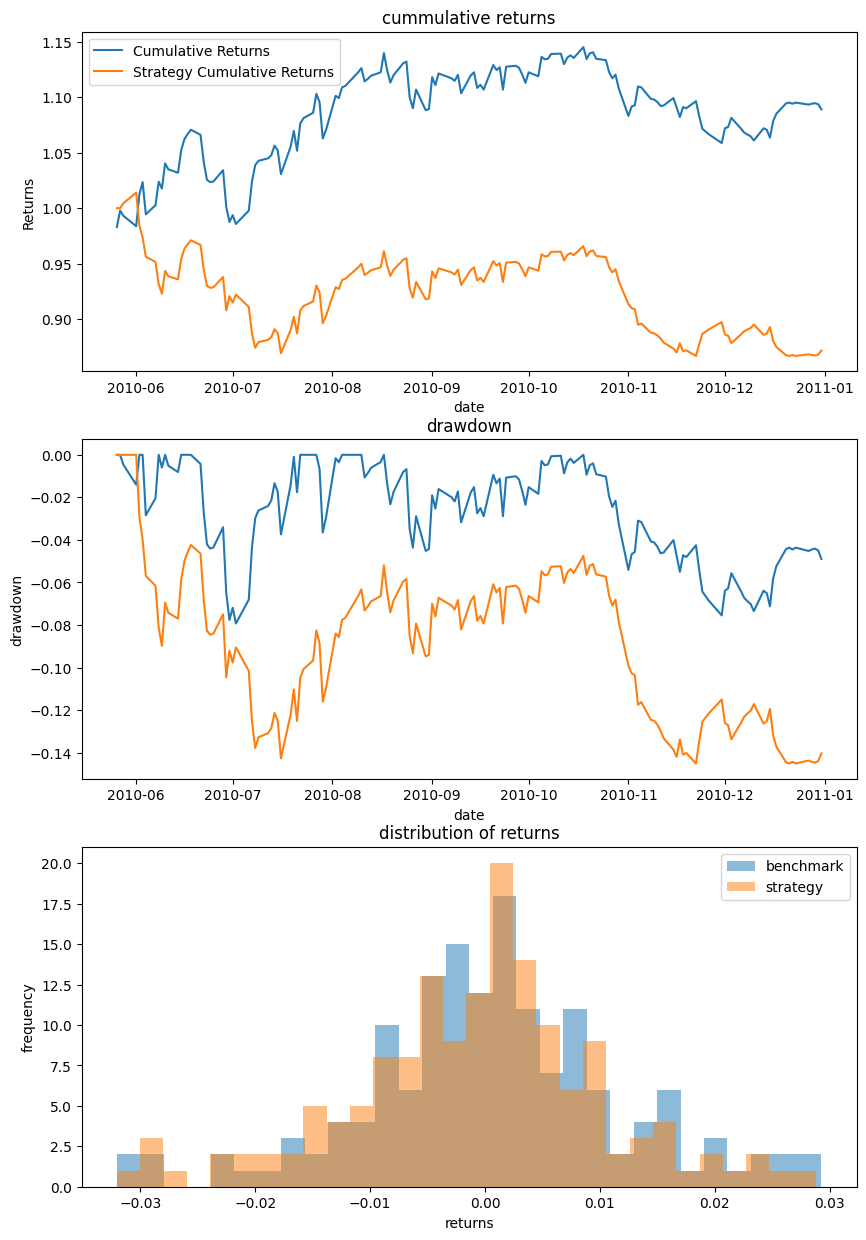

In [82]:
statistics(ret,True)

In [52]:
# strategy hypothesis tests

In [53]:
from scipy.stats import ttest_rel

In [56]:
def strat_1tailed_test(df,print_results=False):
  group1=df.returns
  group2=df.strat_returns
  t_stat, p_value = ttest_rel(group2, group1, alternative='greater')
  if print_results:
    print('mean_returns of benchmark = ',np.mean(group1))
    print('mean_returns of strategy = ',np.mean(group2))
    if p_value>0.01:
      print(f"null hypothesis cannot be rejected for this strategy")
    else:
      print(f"null hypothesis is rejected for this strategy")
  return p_value

In [57]:
strat_1tailed_test(ret)

0.9533316527083318

# VWAP Tests

In [ ]:
VWAP_strat_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  VWAP_strat_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    VWAP_strat_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      df=VWAP_crossover(stock,lookback,start,end)
      p_value = strat_1tailed_test(df)
      if p_value<0.01:
        VWAP_strat_hypothesis_rejected[sector][stock][lookback]=p_value

In [60]:
VWAP_strat_hypothesis_rejected

{'Tech': {'AAPL': {},
  'MSFT': {},
  'NVDA': {},
  'ADBE': {},
  'CRM': {},
  'GOOGL': {},
  'AMZN': {},
  'IBM': {},
  'INTC': {},
  'CSCO': {}},
 'Healthcare': {'JNJ': {},
  'PFE': {},
  'MRK': {},
  'GILD': {},
  'AMGN': {},
  'BMY': {},
  'LLY': {},
  'REGN': {},
  'UNH': {}},
 'Financial': {'JPM': {},
  'BAC': {},
  'WFC': {},
  'C': {},
  'GS': {},
  'MS': {},
  'V': {},
  'MA': {},
  'AXP': {},
  'SCHW': {}},
 'Consumer_D': {'HD': {},
  'MCD': {},
  'NKE': {},
  'SBUX': {},
  'DIS': {},
  'CMCSA': {},
  'LOW': {},
  'GM': {},
  'F': {},
  'BKNG': {}},
 'Consumer_S': {'PG': {},
  'KO': {},
  'PEP': {},
  'WMT': {},
  'CL': {},
  'KMB': {},
  'CLX': {},
  'MDLZ': {},
  'EL': {}},
 'Industrial': {'BA': {},
  'GE': {},
  'MMM': {},
  'HON': {},
  'CAT': {},
  'RTX': {},
  'LMT': {},
  'GD': {},
  'UNP': {},
  'FDX': {}},
 'Energy': {'XOM': {},
  'CVX': {},
  'BP': {},
  'COP': {},
  'EOG': {},
  'OXY': {},
  'SLB': {},
  'KMI': {},
  'WMB': {}},
 'Utility': {'NEE': {},
  'DUK': {},

# MA strat

In [61]:
def data_prep_MA2(symbol,lookback,start,end,smoothing_choice="s"):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  # Calculate the rolling MAs
  if smoothing_choice=='s':
    df['SMA']=df['Close'].rolling(window=lookback).mean()
  elif smoothing_choice=='e':
    df['EMA']=df['Close'].ewm(span=lookback, adjust=False).mean()
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df["day's return"]=(df['Close']-df['Open'])/df['Open']
  df=df.dropna(axis=0)
  return df 

In [65]:
def MA_crossover(symbol,lookback,start,end,smoothing_choice="s",print_trades=False):
  df = data_prep_MA2(symbol,lookback,start,end,smoothing_choice) # prepares the dataset
  df['strat_returns']=np.zeros(len(df)) # initialise the strategy column
  long_trade=False # sets long and short trade indicator to false 
  short_trade=False
  for date in df.index:
    if long_trade: 
      if just_entered:
        if print_trades:
          print('entered long trade',df.loc[date,"day's return"])
        df.loc[date,'strat_returns'] = df.loc[date,"day's return"]
        just_entered=False
      else:        
        if print_trades:
          print('in long trade',df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = df.loc[date,'returns']
    elif short_trade:
      if just_entered:
        if print_trades:
          print('entered short trade',-df.loc[date,"day's return"])
        df.loc[date,'strat_returns'] = -df.loc[date,"day's return"]
        just_entered=False
      else:     
        if print_trades: 
          print('in short trade',-df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = -df.loc[date,'returns']
    else:
      df.loc[date,'strat_returns'] = 0
    # check for ma type
    if smoothing_choice=='e':
      column = 'EMA'
    else:
      column = 'SMA'
    # strategy entry updates 
    if df.loc[date,'Close'] > df.loc[date,column]:
      if long_trade==False:
        just_entered=True
      long_trade=True
      short_trade=False
    else:
      if short_trade==False:
        just_entered=True
      long_trade=False
      short_trade=True
  return df

In [63]:
MA_crossover(symbol='spy',lookback=50,start=start,end=end,smoothing_choice="e")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,EMA,returns,day's return,strat_returns
Date,,,,,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.437500,94.946472,8164300,145.437500,-0.018971,-0.018971,0.000000
2000-01-04,143.531250,144.062500,139.640625,139.750000,91.233429,8089800,145.214461,-0.026344,-0.026344,0.026344
2000-01-05,139.937500,141.531250,137.250000,140.000000,91.396667,12177900,145.009972,0.000447,0.000447,-0.000447
2000-01-06,139.625000,141.500000,137.750000,137.750000,89.927841,6227200,144.725267,-0.013429,-0.013429,0.013429
2000-01-07,140.312500,145.750000,140.062500,145.750000,95.150452,8066500,144.765453,0.038753,0.038753,-0.038753
...,...,...,...,...,...,...,...,...,...,...
2014-12-24,208.020004,208.339996,207.720001,207.770004,178.802673,42963400,202.954772,-0.001202,-0.001202,-0.001202
2014-12-26,208.309998,208.850006,208.250000,208.440002,179.379272,57326700,203.169879,0.000624,0.000624,0.000624
2014-12-29,208.220001,208.970001,208.139999,208.720001,179.620193,79643900,203.387531,0.002401,0.002401,0.002401


# MA Tests

In [ ]:
MA_strat_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  MA_strat_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    MA_strat_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      MA_strat_hypothesis_rejected[sector][stock][lookback]={}
      for ma_type in ['s','e']:
        df=MA_crossover(stock,lookback,start,end,ma_type)
        p_value = strat_1tailed_test(df)
      if p_value<0.01:
        MA_strat_hypothesis_rejected[sector][stock][lookback]=p_value

In [75]:
MA_strat_hypothesis_rejected

{'Tech': {'AAPL': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'MSFT': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'NVDA': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'ADBE': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'CRM': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'GOOGL': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'AMZN': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'IBM': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'INTC': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'CSCO': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}}},
 'Healthcare': {'JNJ': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'PFE': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'MRK': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'GILD': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'AMGN': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'BMY': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'LLY': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'REGN': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'UNH': {9: {}, 20: {}, 50: 